# CCD Test

Developed by Jiwon Jang (starrynight@snu.ac.kr) <br>
Updated at 2024.10.13. <br>

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import pandas as pd
import numpy as np

import cupy as cp #GPU parallel computing (For Fast Processing)
import concurrent.futures #Threading
import gc #Garbage collection - Memory allocation

from pathlib import Path
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from astropy.stats import sigma_clipped_stats
from scipy import odr
from scipy.interpolate import interp1d,CubicSpline

from tqdm import tqdm

# set the params for plot
plt.rcParams['figure.figsize']=[7,5]
#plt.rcParams['lines.linewidth']=2
plt.rcParams['font.size']=14
plt.rcParams['text.usetex']=False
plt.rcParams['axes.linewidth']=1.5
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=7
plt.rcParams['ytick.major.size']=7
plt.rcParams['xtick.minor.size']=3.5
plt.rcParams['ytick.minor.size']=3.5
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.top']=True
plt.rcParams['legend.frameon']=False

In [2]:
#load single frame from file.
def load_frame(path,header=False):
    tmp = pd.read_csv(path, sep=',', header=None, skiprows=4)
    tmp.dropna(axis=1, inplace=True)
    if header:
        df=pd.read_csv(path,sep=':',header=None,nrows=4)
        hdr = [df[1][1],df[1][2],float(df[1][0]),float(df[1][3])] #Quality, Gain, Exposure Time, Sensor Temperature
        return hdr, tmp.values
    else: return tmp.values

#Load Data file with Threading
def frame_bulk_loader(frame_list, label = None, header = False):
    data = []
    if header: 
        hdrs = pd.DataFrame(columns=['Quality','Gain','Exposure','Temperature'])
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(lambda f: load_frame(f, header=True), frame_list), 
                                total=len(frame_list), desc=label))
        for result in results:
            hdrs.loc[len(hdrs)] = result[:1][0] # Header (acq, gain, exptime, temp)
            data.append(result[1])  # Data
        return hdrs, np.array(data)
    else:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            data = list(tqdm(executor.map(load_frame, frame_list), total=len(frame_list), desc=label))
        return np.array(data)

In [12]:
def show_frame(data,return_mean=False):
    xs,ys=np.arange(Ncol),np.arange(Nrow)
    column_val,_,_=sigma_clipped_stats(data,axis=0,sigma=3)
    row_val,_,_=sigma_clipped_stats(data,axis=1,sigma=3)

    axd=plt.figure(constrained_layout=True,figsize=(5.8,5)).subplot_mosaic(
        """
        .a
        bA
        """,
        width_ratios=[1,3],
        height_ratios=[1,3],
        #gridspec_kw={"wspace":-1.3}
    )
    #plt.title(f"Frame {No}_{Ncycle} / {exptime}ms / flat / Temperature={temp:.2f}"+"$^{\\circ}C$",fontsize=9)
    img=axd['A'].imshow(data,cmap='gray',origin='lower',extent=(0,1340,0,1300))
    axd['a'].step(xs,column_val)
    axd['a'].set_xlim([0,Ncol])
    #axd['a'].set_ylim([0,65535])
    axd['a'].get_xaxis().set_visible(False)
    axd['a'].set_ylabel('avg signal[ADU]',fontsize=9)
    axd['b'].step(row_val,ys)
    axd['b'].set_ylim([0,Nrow])
    #axd['b'].set_xlim([0,65535])
    axd['b'].get_yaxis().set_visible(False)
    axd['b'].invert_yaxis()
    axd['b'].invert_xaxis()
    axd['b'].set_xlabel('avg signal[ADU]',fontsize=9)
    plt.colorbar(img,ax=axd['A'],location='right',fraction=0.046)
    plt.show()
    
    if return_mean:
        return row_val, column_val

In [4]:
def linear(x,a,b): return a*x+b

def fitting(func,x,y,p0,bounds=None):
    popt, pcov = curve_fit(func,x,y,p0=p0,bounds=bounds)
    perr = np.sqrt(np.diag(pcov)) #fitting error
    return popt, perr

# 0. Basic Sensor Informations
- Number of pixels for each direction
- Pixel size
- Acquisition Modes

In [5]:
#for PIXIS 1300BX
Nrow,Ncol=1300,1340 #in pixel units.

acquisition = ['LN','HC'] #Low Noise / High Capacity
gain = ['Low','Medium','High']

In [7]:
#Set data path
root_path = Path("C:\SNU\Internship\K-Spec\Sources\Data")
fig_path = Path("C:\\SNU\\Internship\\K-Spec\\논문\\FIgures")
phot_path = root_path / "photon_noise"
dark_path = root_path / "Dark" #this frame acquired under Low Noise, Low gain mode.
flat_path = root_path / 'PTC'
qe_path = root_path / 'QE'

# 1. Bias Characteristics
## 1) Exposure Settings
With Complete Darkness(Take cover on your image sensor),


In [7]:
print("== Load frames ==")
ubias_tot = []
for acq in acquisition:
    for g in gain:
        ubias_path = root_path / f"bias_unilluminated\\{acq}_{g}\\"
        ubias_list = list(ubias_path.glob('frame0000_*_b.txt'))
        ubias = []
        #Load Data file with Threading
        with concurrent.futures.ThreadPoolExecutor() as executor:
                ubias = list(tqdm(executor.map(load_frame, ubias_list), total=len(ubias_list), desc=f'{acq}_{g}'))
        ubias_tot.append(ubias)

== Load frames ==


HC_High: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


## 2) Bias level  variability
Measure fluctuation of bias frames about time

In [8]:
print("== Statistics for each frames ==")
M, S = [],[] #Mean & Std
k=0
for acq in acquisition:
    for g in gain:
        ubias = ubias_tot[k]
        mean, std = np.zeros(len(ubias)), np.zeros(len(ubias))
        for i in tqdm(range(len(ubias)), desc=f'{acq}_{g}'):
            mean[i],_,std[i]=sigma_clipped_stats(ubias[i],sigma=3)
        M.append(mean) 
        S.append(std)
        k+=1

== Statistics for each frames ==


HC_High: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


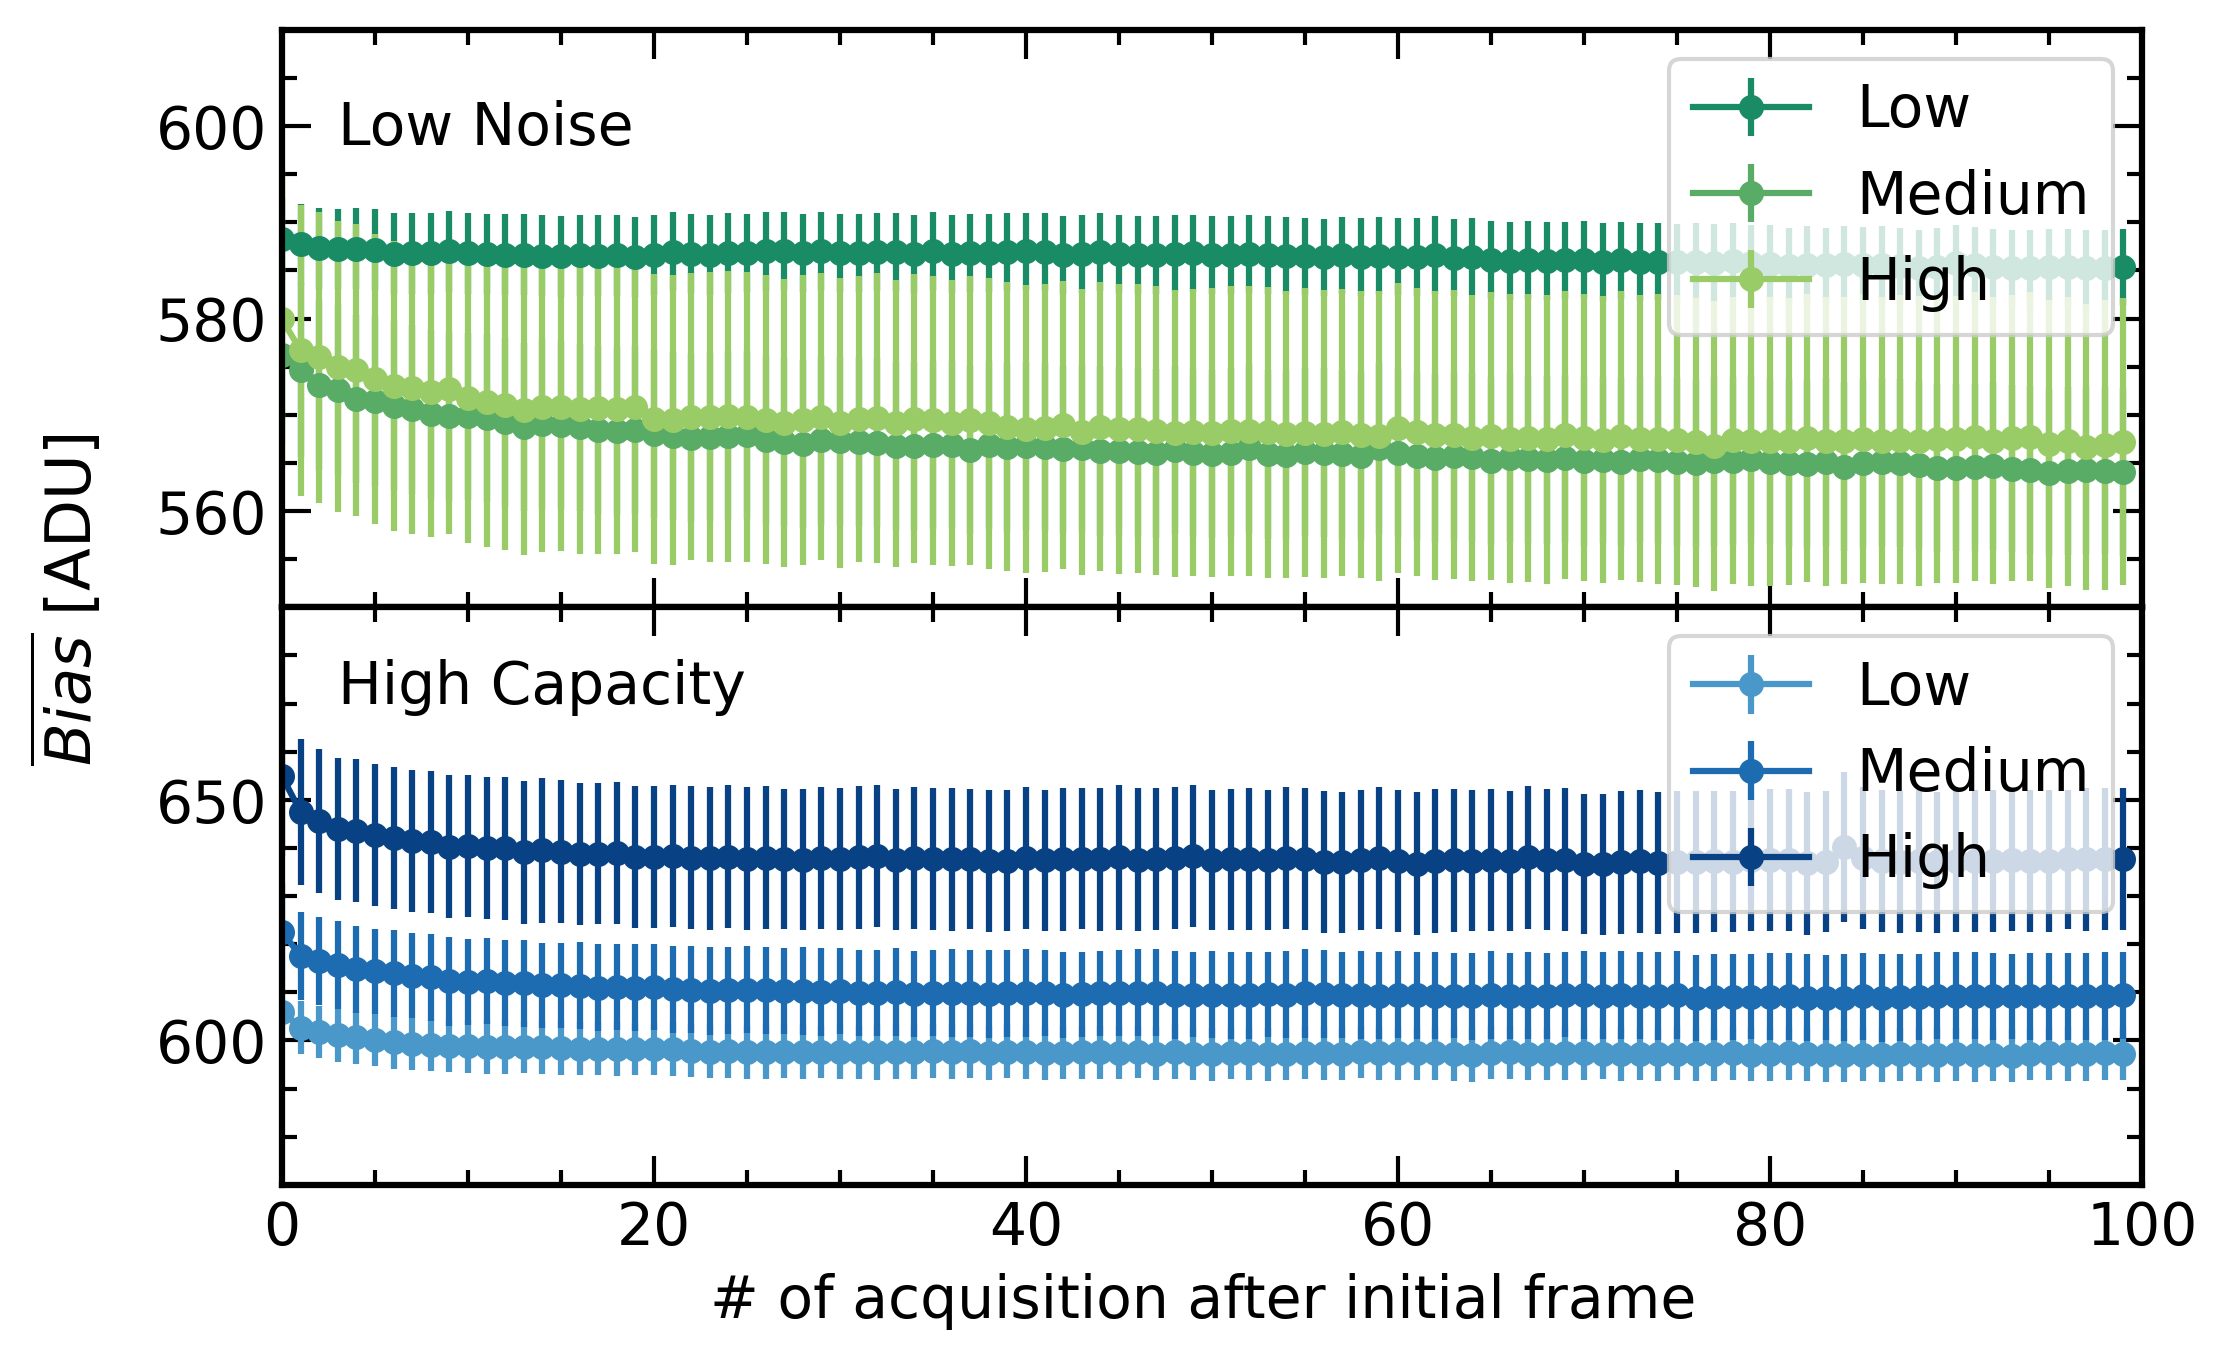

In [8]:
#Plot 
gs = GridSpec(nrows=2,ncols=1,hspace=0)

num = np.arange(0,100)
xt = np.arange(0,120,20)
fig = plt.figure(figsize=(8,5),dpi=300)

# Mean Bias level variation about time
#different acquisiton modes(Hign Capacity/Low Noise)
plt.subplot(gs[0])
for i in range(len(gain)):
    plt.errorbar(num,M[i],yerr=S[i],color=cm.summer(i/4+0.1),label=gain[i],marker='o',ms=5)
plt.text(3,598,'Low Noise')
plt.xlim(0,100)
plt.ylim(550,610)
plt.xticks(xt,[' ' for i in range(len(xt))]) 
plt.legend(loc='upper right',frameon=True)

plt.subplot(gs[1])
for i in range(3,6):
    plt.errorbar(num,M[i],yerr=S[i],color=cm.Blues(i/6+0.1),label=gain[i-3],marker='o',ms=5)
plt.xlabel('# of acquisition after initial frame ')
plt.xlim(0,100)
plt.ylim(570,690)
plt.text(3,670,'High Capacity')
plt.legend(loc='upper right',frameon=True)

fig.supylabel('$\\overline{Bias}$ [ADU]',fontsize=15)
plt.savefig(fig_path/'Bias_stability.png',dpi=300)

## 3) Readout Noise

### 3-1) Single Frame Statistics

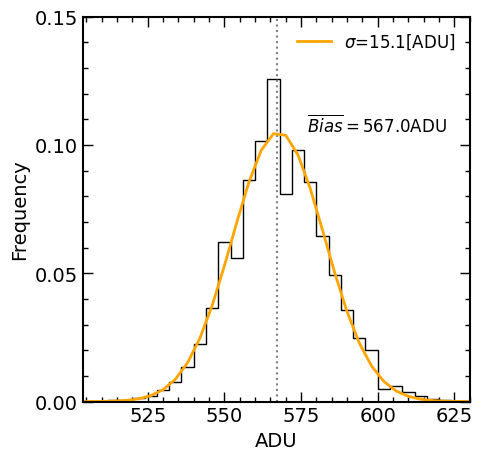

In [9]:
from scipy.odr import *

def normal(p,x):
    return p[0]*np.exp(-(x-p[1])**2/(2*p[2]**2))


plt.figure(figsize=(5,5))
k=2
rand = np.random.randint(0,len(ubias_tot[k]))
b = np.reshape(ubias_tot[k][rand],(-1,1))
freq,bins,_ = plt.hist(b,bins=50,range=(500,700),histtype='step',color='k',weights=np.ones(len(b))/len(b))
binc = 0.5*(bins[1:]+bins[:-1])
plt.axvline(np.median(b),ls='dotted',color='gray')

data = Data(binc,freq)
#tarr=np.linspace(min(time),max(time))

b_median, b_std = np.median(b), np.std(b)
model=Model(normal)
odrfit=ODR(data,model,beta0=[1,b_median,b_std]) #Beta0 : initial condition
fit=odrfit.run() #fitting process => Beta, Residual...

plt.plot(binc,normal(fit.beta,binc),color='orange',label=f'$\\sigma$={fit.beta[2]:.1f}[ADU]',lw=2)
plt.xlabel("ADU")
plt.ylabel("Frequency")
plt.text(b_median+10,fit.beta[0]
         ,s='$\\overline{Bias}=$'+f'{b_median}ADU',fontsize=12)
plt.yticks(np.arange(0,0.2,0.05))
plt.xlim(b_median-4*b_std,b_median+4*b_std)
plt.legend(fontsize=12)

plt.savefig(fig_path/'bias_stats.png',dpi=300, bbox_inches="tight")

### 3-2) Multiple Frame Statistics

In [9]:
#For fast calculation, you need GPU in your system.
def calc_difference(frames, device=0):
    # Calculate difference between frames
    mean, std = [], []
    num_frames = len(frames)
    with cp.cuda.Device(device): #GPU Parallel Computing
        frames = cp.array(frames)  
        for i in tqdm(range(num_frames)):
            diffs = frames[i] - frames[i+1:num_frames]  # Vectorized difference calculation
            diffs_mean = cp.abs(cp.mean(diffs,axis=(1,2)))
            diffs_std = cp.std(diffs,axis=(1,2)) / cp.sqrt(2)
            
            mean.extend(diffs_mean.tolist())
            std.extend(diffs_std.tolist())
    
    return np.array(mean), np.array(std)

In [10]:
ubias_mean_tot, ubias_std_tot = [], []
k=0
for acq in acquisition:
    for g in gain:
        mean_tmp, std_tmp = calc_difference(ubias_tot[k])
        ubias_mean_tot.append(mean_tmp)
        ubias_std_tot.append(std_tmp)
        print(f"{acq}_{g} / Readout Noise = {np.median(std_tmp):.3f}ADU") #Median Value of Readout Noise
        k+=1

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.96it/s]


LN_Low / Readout Noise = 3.917ADU


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.31it/s]


LN_Medium / Readout Noise = 7.567ADU


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.02it/s]


LN_High / Readout Noise = 13.772ADU


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.34it/s]


HC_Low / Readout Noise = 2.686ADU


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.17it/s]


HC_Medium / Readout Noise = 4.859ADU


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.56it/s]

HC_High / Readout Noise = 9.379ADU


In [53]:
def draw_rdn_plot(x, y,label, fm = 0.94, fM = 1.003 , std_bound = (0,0)):
    # x: mean difference
    # y: standard deviation
    
    mean_max = round(max(x),0)+1
    std_min, std_max = std_bound
    if std_bound[0]==0: std_min = round(min(y),1)-0.03
    if std_bound[1]==0: std_max = round(max(y),1)+0.03
    
    #mbins = np.arange(-0.5,mean_max+0.5,0.5)

    gs = GridSpec(nrows=2,ncols=2,hspace=0,wspace=0,
                  height_ratios=(1,3),width_ratios = (3,1))
    fig = plt.figure(figsize=(7,7))

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted on top
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    #histogram - mean deviation 
    ax1 = plt.subplot(gs[0,0])
    mcounts,mbins =np.histogram(x,bins=30)
    mbinc = 0.5*(mbins[:-1]+mbins[1:])
    mfreq = mcounts/len(x)
    ax1.fill_between(mbinc,mfreq, step="pre",color='steelblue',alpha=0.6)
    ax1.set_xlim(0,mean_max)
    #ax1.set_ylim(0,0.5)
    ax1.set_yscale('log')
    ax1.set_xticklabels('')
    ax1.set_ylabel('Frequency')

    #Histogram - stdev(RDN)
    ax2 = plt.subplot(gs[1,1])
    counts,bins=np.histogram(y,bins=30)
    freq = counts/len(y)
    binc = 0.5*(bins[:-1]+bins[1:])
    ax2.fill_between(freq, binc, step="pre",color='yellowgreen',alpha=0.6)
    ax2.set_yticklabels('')
    ax2.set_ylim(std_min, std_max)
    ax2.axhline(np.median(y),color='gray',ls='dotted')
    ax2.text(0.13,np.median(y)+0.01,s='$\\overline{\\sigma_{RDN}}=$'+f'{np.mean(y):.1f}',
             horizontalalignment='right',fontsize=12)
    ax2.set_xscale('log')
    ax2.set_xlim(5e-4,0.2)
    ax2.set_xlabel('Frequency')
    
    #Scatter plot - Mean deviation - Stdev(RDN)
    ax = plt.subplot(gs[1,0])
    scat = ax.scatter(x, y, c=np.log10(z), s=10, edgecolor='k',lw=0.2,cmap='RdYlBu_r')
    fig.colorbar(scat, ax=ax2,label='$\\rm log_{10}$(Density)')
    ax.set_xlabel('Mean Difference [ADU]')
    ax.set_ylabel('$\\sigma_{RDN}$ [ADU]')
    ax.text(mean_max*fm,std_min*fM,s=label, horizontalalignment='right',fontsize=18)
    ax.set_xlim(0,mean_max)
    ax.set_ylim(std_min, std_max)
    return freq

### a) Low Noise Mode

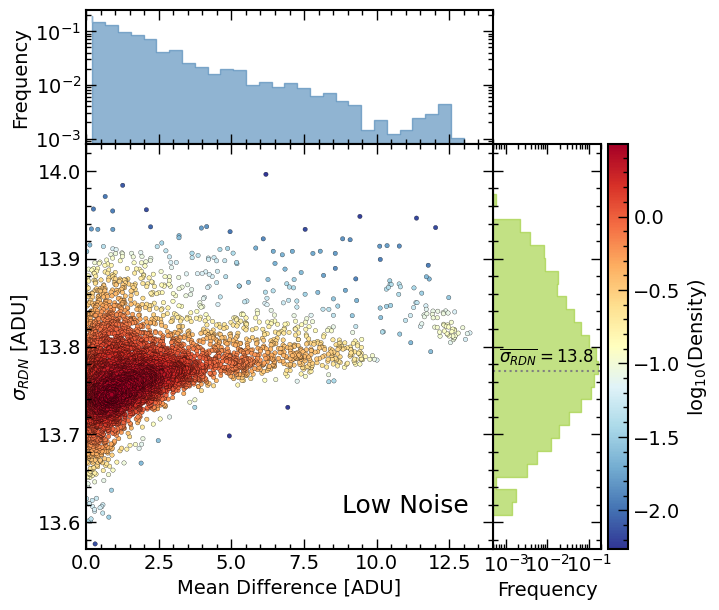

In [29]:
x, y = ubias_mean_tot[2], ubias_std_tot[2]
freq=draw_rdn_plot(x, y,label='Low Noise', fm = 0.94, fM = 1.003 )
plt.savefig(fig_path/'RDN_LowNoise_unilum.png',dpi=300)

### b) High Capacity Mode

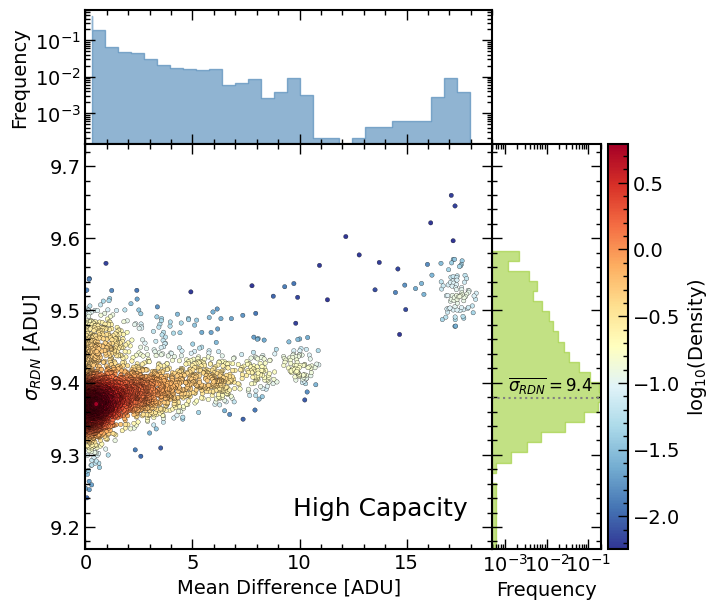

In [32]:
x, y = ubias_mean_tot[5], ubias_std_tot[5]
draw_rdn_plot(x, y,label='High Capacity', fm = 0.94, fM = 1.005)
plt.savefig(fig_path/'RDN_HighCap_unilum.png',dpi=300)

## Photon noise

In [33]:
acquisition = ['LN']
gain = ['High'] #Reccomend for testing under High-gain mode (G = 1e/ADU)

print("== Load frames ==")
ubias_tot, bias_tot = [], []
for acq in acquisition:
    for g in gain:
        ubias, bias = [], []
        #Bias frame without light
        ubias_path = phot_path / f"unilluminated\\{acq}_{g}\\"
        ubias_list = list(ubias_path.glob('frame0000_*_b.txt'))
        
        #Bias frame with light
        bias_path = phot_path / f"illuminated\\{acq}_{g}\\"
        bias_list = list(bias_path.glob('frame0000_*_b.txt'))
        
        #Load Data file with Threading
        ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g}(Unilluminated)')
        bias = frame_bulk_loader(bias_list, label=f'{acq}_{g}(Illuminated)')

        ubias_tot.append(ubias)
        bias_tot.append(bias)

== Load frames ==


LN_High(Illuminated): 100%|██████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.10it/s]


In [34]:
#Calculate Statistics
ubias_mean_tot, ubias_std_tot = [], []
bias_mean_tot, bias_std_tot = [], []
k=0
for acq in acquisition:
    for g in gain:
        mean_ubias, std_ubias = calc_difference(ubias_tot[k])
        mean_bias, std_bias = calc_difference(bias_tot[k])

        ubias_mean_tot.append(mean_ubias)
        ubias_std_tot.append(std_ubias)
        print(f"{acq}_{g} / Readout Noise(Unilluminated) = {np.median(std_ubias):.3f}ADU") #Median Value of Readout Noise

        bias_mean_tot.append(mean_bias)
        bias_std_tot.append(std_bias)
        print(f"{acq}_{g} / Readout Noise(Illuminated) = {np.median(std_bias):.3f}ADU") 
        
        k+=1

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.07it/s]

LN_High / Readout Noise(Unilluminated) = 13.671ADU
LN_High / Readout Noise(Illuminated) = 104.765ADU


### a) Complete Darkness

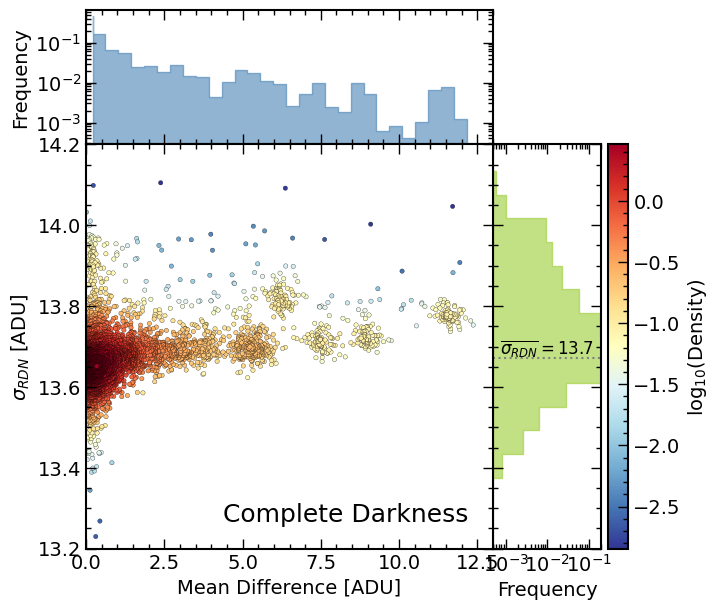

In [54]:
x, y = ubias_mean_tot[0], ubias_std_tot[0]
freq=draw_rdn_plot(x, y,label='Complete Darkness', fm = 0.94, fM = 1.005, std_bound = (13.2,14.2))
plt.savefig(fig_path/'RDN_LN_CompleteDark.png',dpi=300, bbox_inches='tight')

### b) Under Illumination

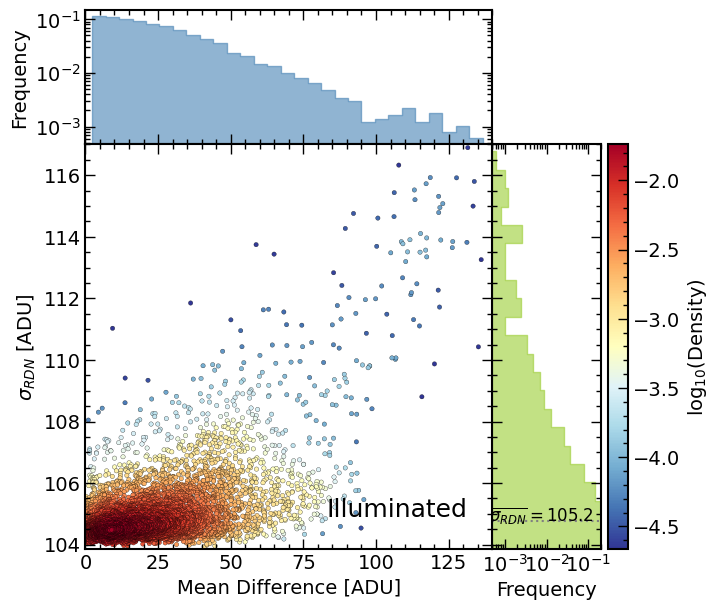

In [56]:
x, y = bias_mean_tot[0], bias_std_tot[0]
freq=draw_rdn_plot(x, y,label='Illuminated',fM=1.01,std_bound=(0,117))
plt.savefig(fig_path/'RDN_LN_HighIllum.png',dpi=300, bbox_inches='tight')

# 2. Dark Characteristics
Take frames with different exposure times sequentially. <br>
For Successive measurements, exposure might be longer than 30s. <br>
Dark current is supposed to increase linearly over time, so it is recommended that you obtain a frame with the same time interval. 

In [8]:
#Load dark frames
bias,dark = [], []
tarr = []

darklist = list(dark_path.glob('*degC'))
Tarr = np.zeros(len(darklist)) #Testing Sensor Temperature

print("== Load frames ==")
for k in range(len(darklist)):
    dark_frame_list = list((darklist[k] / "single").glob("frame*.txt"))
    hdrs, dark_tmp = frame_bulk_loader(dark_frame_list, label=darklist[k].stem, header=True)
    Tarr[k] = hdrs['Temperature'][0]
    tarr.append(hdrs['Exposure'].values) #Exposure time array
    dark.append(dark_tmp)
    bias.append(dark_tmp[0])
    
bias = np.array(bias)
#The number of Dark frames may not equal to each sensor temperature.

== Load frames ==


00degC: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.20it/s]


### Bias level Temperature dependancy

In [29]:
#Mean intensity variation
mean_bias,median_bias,std_bias=sigma_clipped_stats(bias.reshape(-1,Ncol*Nrow),sigma=3.0,axis=1)

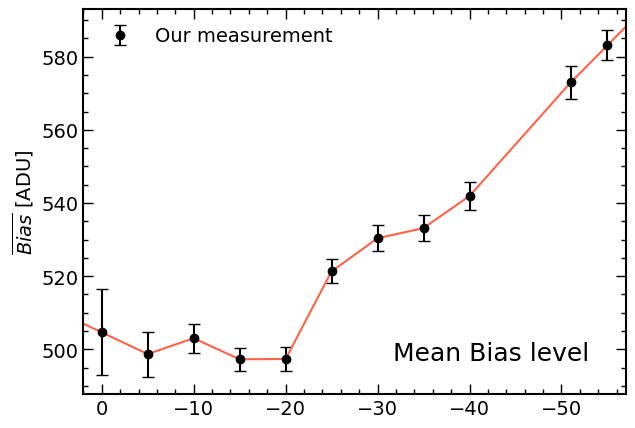

In [31]:
Ts=np.linspace(min(Tarr)-2,max(Tarr)+2,1000)
fbT = interp1d(Tarr,mean_bias,kind=1,fill_value='extrapolate')

plt.errorbar(Tarr,mean_bias,yerr=std_bias,linestyle='None',capsize=4,color='k',marker='o',label='Our measurement')
plt.plot(Ts,fbT(Ts),color='tomato')
plt.ylabel('$\\overline{Bias}$ [ADU]')
plt.yticks([500,520,540,560,580])
plt.text(-53,497,s='Mean Bias level',horizontalalignment='right',fontsize=18)
plt.xlim(2,-57)
plt.legend()

### Dark current measurment

In [9]:
def linear(x,a,b):
    return a*x+b

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\jiwon\AppData\Local\Temp\ipykernel_27484\2977337185.py:11: RuntimeWarning: invalid value encountered in sqrt
  perr = np.diag(np.sqrt(pcov))
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:36<00:00,  3.32s/it]


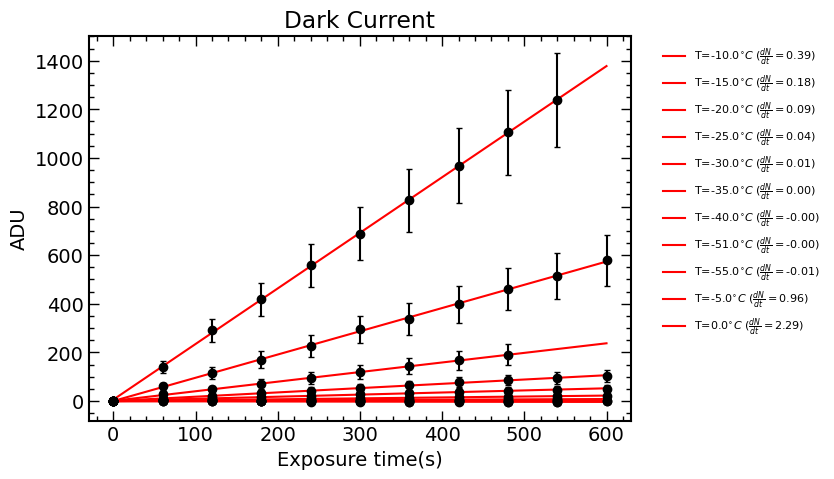

In [10]:
DarkCurrent, DarkCurrent_err= np.zeros(len(Tarr)), np.zeros(len(Tarr))
ts=np.linspace(0, 600,100)
 
for k in tqdm(range(len(Tarr))):
    dark_biassub = dark[k]-bias[k]
    darr = dark_biassub.reshape(-1,Ncol*Nrow)
    mean,median,std=sigma_clipped_stats(darr,sigma=3.0, axis=1)
    
    #Linear Fitting
    popt,pcov=curve_fit(linear,tarr[k],mean,p0=[0,0])
    perr = np.diag(np.sqrt(pcov))
    DarkCurrent[k],DarkCurrent_err[k] =popt[0], perr[0]
    
    plt.errorbar(tarr[k], mean, yerr=std, linestyle='None',capsize=2,color='black',marker='o')
    plt.plot(ts,linear(ts,*popt),color='red',label=f"T={Tarr[k]}"+"$^{\\circ}C$ ($\\frac{dN}{dt}=$"+f"{popt[0]:.2f})")
    
plt.title("Dark Current")
plt.xlabel('Exposure time(s)')
plt.ylabel('ADU')
plt.legend(fontsize=8, bbox_to_anchor=(1.04, 1))
plt.show()

### Temperature variation of dark current

In [38]:
kB=1.381e-23 #Boltzmann constant
def func(p,T):
    Tk=T+273.15 #degC->K
    return p[0]*Tk**(3/2)*np.exp(-p[1]/Tk)

gain = 4.13 #from PTC(Low Noise / Low Gain)

#ODR(orthogonal distance regression) for Non-linear Fitting
model=odr.Model(func)
mask = (Tarr>-30)

data=odr.RealData(Tarr[mask],gain*DarkCurrent[mask])
fodr=odr.ODR(data,model,beta0=[1e11,1.3e4])
fit=fodr.run()

Ts=np.linspace(min(Tarr)-2,max(Tarr)+2,1000)
fit_val=func(fit.beta,Ts)

beta, err = fit.beta, np.sqrt(np.diag(fit.cov_beta))
Eg, dEg = beta[1]*(2*kB)/(1.602e-19), err[1]*(2*kB)/(1.602e-19) #Energy band Gap

C:\Users\jiwon\AppData\Local\Temp\ipykernel_27484\2420546014.py:4: RuntimeWarning: overflow encountered in exp
  return p[0]*Tk**(3/2)*np.exp(-p[1]/Tk)


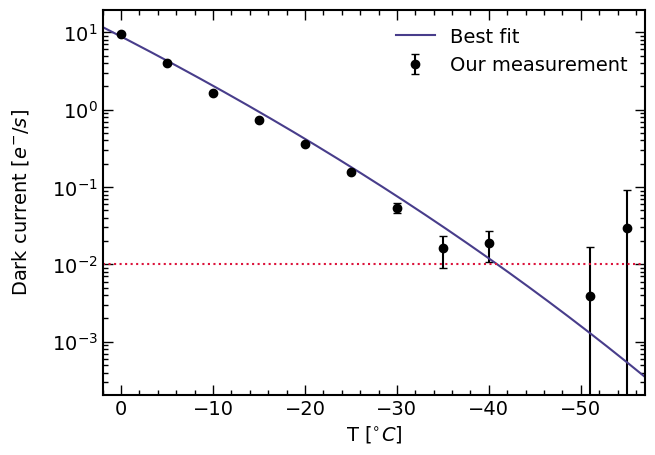

In [41]:
plt.errorbar(Tarr,gain*abs(DarkCurrent),yerr=gain*DarkCurrent_err,color='k',capsize=3,marker='o',ls='None',label='Our measurement')
plt.plot(Ts,fit_val,color='darkslateblue',label='Best fit')
plt.gca().invert_xaxis()
plt.xlabel('T $[^{\\circ}C]$')
plt.ylabel('Dark current $[e^{-}/s]$',labelpad=15)
plt.xlim(2,-57)
plt.axhline(1e-2,ls='dotted',color='crimson')
#plt.text(-36,1,s='b) Dark Current', weight='bold')
plt.yscale('log')
plt.legend()
plt.savefig('C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\Dark.png',dpi=300)

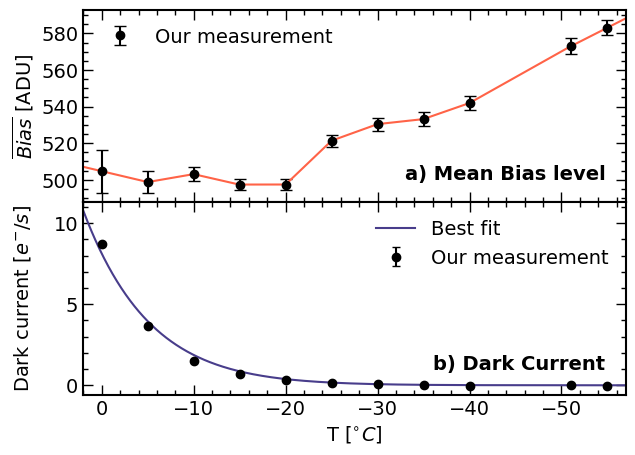

In [106]:
gs = GridSpec(nrows=2,ncols=1,hspace=0)

plt.subplot(gs[0])
plt.errorbar(Tarr,mean_bias,yerr=std_bias,linestyle='None',capsize=4,color='k',marker='o',label='Our measurement')
plt.plot(Ts,fbT(Ts),color='tomato')
plt.ylabel('$\\overline{Bias}$ [ADU]')
plt.yticks([500,520,540,560,580])
plt.text(-33,500,s='a) Mean Bias level', weight='bold')
plt.xlim(2,-57)
plt.legend()

plt.subplot(gs[1])
plt.errorbar(Tarr,gain*DarkCurrent,yerr=gain*DarkCurrent_err,color='k',capsize=3,marker='o',ls='None',label='Our measurement')
plt.plot(Ts,fit_val,color='darkslateblue',label='Best fit')
plt.gca().invert_xaxis()
plt.xlabel('T $[^{\\circ}C]$')
plt.ylabel('Dark current $[e^{-}/s]$',labelpad=15)
plt.xlim(2,-57)
plt.text(-36,1,s='b) Dark Current', weight='bold')
plt.legend()#loc='lower left')
#plt.yscale('log')

#plt.savefig('C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\Bias_Dark.png',dpi=300)

# 3. FWC & PTC
This cells are made to measure FWC(Full Well Capacity) and PTC(Photon Transfer Curve) <br>
To obtain those curves, you should obtain frames with different illumination level. (Controling Exposure time) <br>

For FWC Measurement : First, Determine the maximal exposure time which shows saturation level(for 16bit CCD, 65535ADU).
And set proper time interval between 0s to maximal exposure time. <br> (Optional) Nearby 0s exposure, CCD may works non-lineary. Take additional frames with more finer time interval in that regime. <br>

For PTC Measurement : Short exposure is much important than FWC Measurement. Divide exposure time with logarithmic scale.
(For example, 1-10ms(1ms interval) / 10ms - 100ms(10ms interval) / 100ms-1s(100ms interval))

In [10]:
#Load flat frames
acq, g = 'LN','Low'
#fwc_path = root_path / 'ex/PTC_LN_Low/600nm'
#batch_list = list(fwc_path.glob('*'))

batch_list = list((flat_path/f'{acq}_{g}').glob('*'))

print("== Load frames ==")
bias, flat, tarr = [], [], []
for batch_path in batch_list:
    if batch_path.suffix == '.txt': continue
    flat_frame_list = list(batch_path.glob('frame*.txt')) #to exclude readme.txt
    hdrs, flat_tmp = frame_bulk_loader(flat_frame_list, label=f'{acq}_{g} / batch {batch_path.stem}', header=True)
    
    Ncycle = len(hdrs[hdrs['Exposure']==hdrs['Exposure'][0]]) #the number of iterations per each exposure time
    tarr.append(np.unique(hdrs['Exposure'].values)) #Exposure time array
    flat.append(flat_tmp)
    bias.append(flat_tmp[hdrs['Exposure']==0.]) #Load illuminated bias 
    
bias = np.array(bias)
Nbatch = len(flat) #the number of division of dataset

#Load unilluminated bias
ubias_path = root_path / f"bias_unilluminated\\{acq}_{g}\\" 
ubias_list = list(ubias_path.glob('frame*.txt'))
ubias_hdrs, ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g} / Unilum. bias', header=True)

#Create Master bias frame
print("== Master Bias frames ==")
ubias_r = np.array(ubias).reshape(-1,Ncol*Nrow)
master_ubias,_,_ = sigma_clipped_stats(ubias_r,axis=0,sigma=3.)
master_ubias = master_ubias.reshape(Nrow,Ncol)
print('Unilluminated bias - Done')

bias_r = np.array(bias).reshape(-1,Ncol*Nrow)
master_bias,_,_ = sigma_clipped_stats(bias_r,axis=0,sigma=3.)
master_bias = master_bias.reshape(Nrow,Ncol)
print('Illuminated bias - Done')

#Gradient Correction
master_grad = master_bias-master_ubias

== Load frames ==


LN_Low / Unilum. bias: 100%|█████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


== Master Bias frames ==
Unilluminated bias - Done
Illuminated bias - Done


## Gradient Correction - Excessive Exposure Time
It is important to correct the gradiant effect by image readout process.

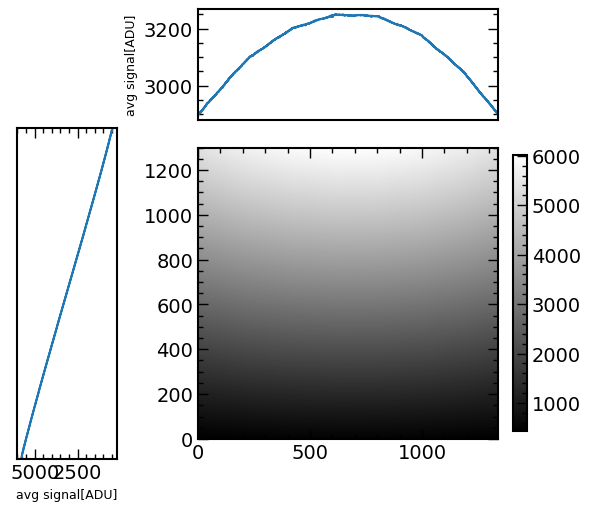

In [13]:
show_frame(master_grad)

C:\Users\jiwon\AppData\Local\Temp\ipykernel_31572\1035578351.py:6: RuntimeWarning: invalid value encountered in divide
  diff = (flat[k][Ncycle*i]-flat[k][0])/delta
C:\Users\jiwon\AppData\Local\Temp\ipykernel_31572\1035578351.py:9: RuntimeWarning: divide by zero encountered in divide
  row_val,_,_=sigma_clipped_stats(master_grad/diff,axis=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


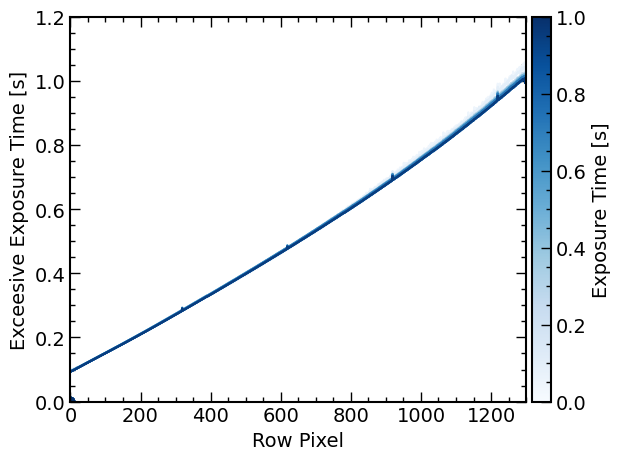

In [76]:
k=1

for i in range(0,len(tarr[k]),1):
    t1, t2 = tarr[k][0], tarr[k][i]
    delta = (t2-t1)/1000 #time interval between two frames
    diff = (flat[k][Ncycle*i]-flat[k][0])/delta

    #Excessive Exposure TIme
    row_val,_,_=sigma_clipped_stats(master_grad/diff,axis=1)

    tmin, tmax = row_val[0], row_val[-2]
    plt.plot(row_val[:-2],color=cm.Blues(i/len(tarr[k])))#,label=f'{tarr[k][i]/1000} s')#'royalblue')

sc = plt.scatter(-10*np.zeros(len(tarr[k])),-10*np.zeros(len(tarr[k])),c=tarr[k]/1000,cmap='Blues')
plt.colorbar(sc, label='Exposure Time [s]', pad=0.01)
plt.xlabel("Row Pixel")
plt.ylabel("Exceesive Exposure Time [s]")
plt.xlim(0,Nrow)
plt.ylim(0,1.2)
plt.legend(bbox_to_anchor = (1.02,1))
#plt.text(Nrow*0.94,tmin*1.2,s=f'{acq} {g}',horizontalalignment='right',fontsize=18)
plt.savefig(fig_path / f'Ext\\ExT.png', dpi=300,bbox_inches='tight')

## Masking
To ensure uniform exposure, cutout central region.

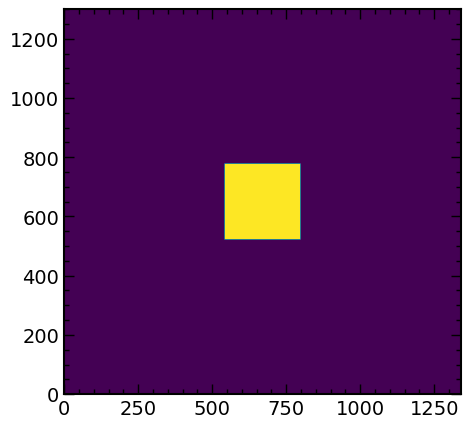

In [43]:
#Masked image (100x100 flat region)
boxsize=256
bh=boxsize//2
xcen = Ncol//2
ycen = Nrow//2
#ycen=Nrow-xcen

mask=np.zeros((Nrow,Ncol))
mask[ycen-bh:ycen+bh,xcen-bh:xcen+bh]=1
plt.imshow(mask,origin='upper',extent=(0,1340,0,1300))

### Measuring Signal($S$) & Temporal Noises($\sigma$)

In [78]:
counts, signal, noise = [],[],[]
for n in range(Nbatch):
    for k in tqdm(range(len(tarr[n])),desc=f'Batch {n}'):
        flat_tmp = flat[n][k*Ncycle:(k+1)*Ncycle]
        corr = flat_tmp - master_ubias - master_grad #True signal
        #Crop central region for ensure uniformity
        flat_clipped = flat_tmp[:,ycen-bh:ycen+bh,xcen-bh:xcen+bh]
        corr_clipped = corr[:,ycen-bh:ycen+bh,xcen-bh:xcen+bh] 
        
        C = np.mean(flat_clipped) #Average counts
        E = np.mean(corr_clipped,axis=0) #Average exposed frame
        S = np.mean(E)
        N = corr_clipped-S #Noise frames
        
        temporal_noise = np.std(N,axis=(1,2))
        noise.append(np.sqrt(np.mean(temporal_noise**2)))
        counts.append(C)
        signal.append(S)
        
counts, signal, noise = np.array(counts), np.array(signal), np.array(noise)

#total noise function fitting
def total_noise(S,G,RON,P_FPN):
    return np.sqrt(RON**2+S/G+(P_FPN*S)**2)

#initial conditions
p0=np.array([4.7,45,0.003])
#p0 = np.array([1,100,0.003])
#p0 = np.array([12,10,0.003])

mask = (10<signal)&(signal<45000) #Data Mask
ptc_params, ptc_perr = fitting(total_noise,signal[mask],noise[mask],p0,bounds=[[1,1,0],[18,200,0.5]])
#ptc_params : Readout noise / Gain / P_FPN

t = np.hstack(tarr)/1000 #time array(seconds)
#sort data points
_, uidx = np.unique(t,return_index=True) #select unique datapoints
data = np.vstack([t,signal,counts])[:,uidx]
t_sorted, s_sorted, c_sorted = data[:,data[0].argsort()]

Batch 2: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  3.85it/s]


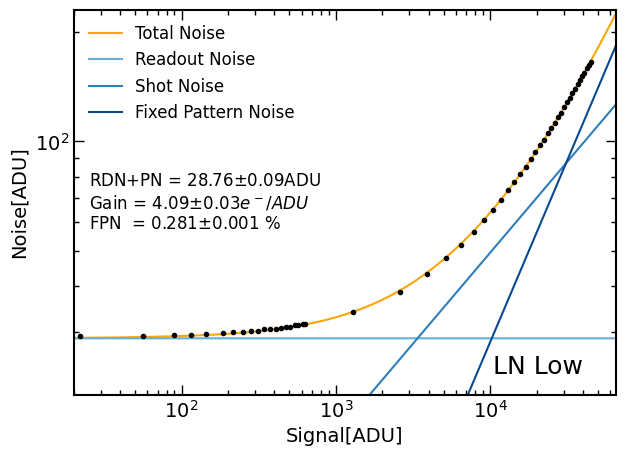

In [53]:
s=np.logspace(0,5,2000)

plt.figure(figsize=(7,5))
plt.errorbar(signal[mask],noise[mask],color='k',ms=3,capsize=3,marker='o',ls='None')
plt.plot(s,total_noise(s,*ptc_params),label='Total Noise',color=cm.inferno(0.8))
plt.plot(s, np.ones(len(s))*ptc_params[1],label='Readout Noise',color=cm.Blues(0.5))
plt.plot(s, np.sqrt(s/ptc_params[0]),label='Shot Noise',color=cm.Blues(0.7))
plt.plot(s, s*ptc_params[2],label='Fixed Pattern Noise',color=cm.Blues(0.9))

plt.xscale('log')
plt.yscale('log')
#plt.ylim(50,500)

#plt.xlim(100,65535)
plt.xlim(20,65535)
plt.ylim(ptc_params[1]*0.7,ptc_params[1]*8)
#plt.ylim(2,300)
plt.xlabel("Signal[ADU]")
plt.ylabel("Noise[ADU]")
plt.text(25,ptc_params[1]*2.,f"RDN+PN = {ptc_params[1]:.2f}$\\pm${ptc_perr[1]:.2f}ADU \nGain = {ptc_params[0]:.2f}$\\pm${ptc_perr[0]:.2f}$e^-/ADU$\nFPN  = {ptc_params[2]*100:.3f}$\pm${ptc_perr[2]*100:.3f} %", fontsize=12)
plt.text(40000,ptc_params[1]*0.8,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

plt.legend(frameon=False,fontsize=12,loc='upper left')

#Residual 추가하기?
plt.savefig(f'C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\\PTC_revised\\PTC_{acq}_{g}.png',dpi=300, bbox_inches="tight")

## FWC

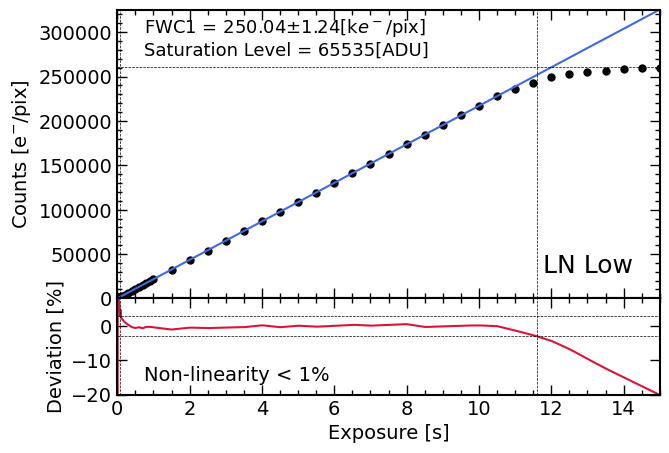

In [88]:
#Gain of CCD
G = ptc_params[0]
Gerr = ptc_perr[0]

#Linear Fitting of linear region
tmax = 15#t_sorted[-1] #2.5
mask = ((10<s_sorted)&(s_sorted<50000)&(t_sorted<tmax))
popt, pcov= curve_fit(linear,t_sorted[mask],s_sorted[mask])
perr = np.sqrt(np.diag(pcov))

linearity = 3#1.2#linearity criteria, %

ts = np.linspace(0,tmax,1000)

#Deviation from linear fitting
dev = (s_sorted-linear(t_sorted,*popt))/linear(t_sorted,*popt)*100

interp = interp1d(t_sorted,dev,kind=1)#interpolate.CubicSpline(t,dev,bc_type='natural')

t_low = ts[np.argmin(abs(interp(ts)-linearity))] #lower limit of linearity
t_sat = ts[np.argmin(abs(interp(ts)+linearity))] #upper limit of linearity

#Full Well Capacity
FWC = G*(linear(t_sat,*popt)-linear(t_low,*popt))
FWC_err = FWC*np.sqrt((Gerr/G)**2+(perr[1]/(linear(t_sat,*popt)-linear(t_low,*popt)))**2)

#dev2 = (signal-linear(t,*popt2))/linear(t,*popt2)*100
#interp2 = interpolate.interp1d(t,dev2,kind=1)
#t_sat2 = ts[np.argmin(abs(interp2(ts)+linearity))]
#FWC2 = G*(linear(t_sat2,*popt)-linear(t_sat,*popt))
#FWC2_err = FWC2*np.sqrt((Gerr/G)**2+(perr2[1]/(linear(t_sat2,*popt2)-linear(t_sat,*popt)))**2)

saturation_counts = int(max(counts))
saturation_signal = int(max(signal))
#bias_level = popt[1]

fig = plt.figure()#figsize=(6,6))
gs = GridSpec(nrows = 2, ncols =1, height_ratios = [3,1], hspace=0)

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

#Top - Linearity curve
ax.plot(t_sorted,G*s_sorted,color='k',ls='None',marker='o',ms=5)
ax.plot(ts,G*linear(ts,*popt),color='royalblue',label='1st linear region')
ax.axvline(t_sat,ls='dashed',lw=0.5,color='k')
ax.axvline(t_low,ls='dashed',lw=0.5,color='k')
ax.axhline(G*saturation_signal,ls='dashed',color='k',lw=0.5)
ax.text(tmax*0.05,G*saturation_signal*1.05,f'FWC1 = {FWC/1e3:.2f}$\\pm${FWC_err/1e3:.2f}[k$e^-$/pix]\nSaturation Level = {saturation_counts}[ADU]',fontsize=13)
ax.text(tmax*0.95,G*7000,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

ax.set_xlim(0,tmax)
ax.set_ylim(0,G*saturation_signal*1.25)#G*linear(ts[-1],*popt))
#ax.set_ylim(0,500000)
ax.set_ylabel("Counts [$\\rm e^{-}/pix$]")
ax.xaxis.set_tick_params(labelbottom=False)

#2nd Linear Regime
#ax.plot(ts,G*linear(ts,*popt2),color='steelblue',label='2nd linear region')
#ax.axvline(t_sat2,ls='dashed',lw=0.5,color='k')
#ax.text(1,G*saturation*1.1,f'FWC1 = {FWC/1e3:.2f}$\\pm${FWC_err/1e3:.2f}[k$e^-$/pix]\nFWC2 = {FWC2/1e3:.2f}$\\pm${FWC2_err/1e3:.2f}[k$e^-$/pix]\nSaturation Level = {saturation}[ADU]',fontsize=13)
#\nBias Level = {bias_level:.1f}'
#ax.legend(loc='lower right')

#Bottom - Deviation from linear response
#ax2.plot(t_sorted,dev, color='crimson',marker='o',ms=3,ls='None')
ax2.plot(ts,interp(ts), color='crimson')
ax2.set_ylabel("Deviation [%]")
ax2.set_yticks([0,-10,-20])
ax2.set_xlim(0,tmax)
ax2.set_ylim(-20,8)
ax2.text(tmax*0.05,-16,"Non-linearity < 1%")
ax2.axvline(t_low,ls='dashed',lw=0.5,color='k')
ax2.axvline(t_sat,ls='dashed',lw=0.5,color='k')
ax2.axhline(linearity,color='k',ls='dashed',lw=0.5)
ax2.axhline(-linearity,color='k',ls='dashed',lw=0.5)
ax2.set_xlabel("Exposure [s]")


#ax3 = fig.add_axes([0.24, 0.55, 0.2, 0.2])
#ax3.plot(t_sorted,G*s_sorted,color='k',ls='None',marker='o',ms=5)
#ax3.plot(ts,G*linear(ts,*popt),color='royalblue')
#ax3.set_xlim(0,0.11)
#ax3.set_ylim(0,2800)

#ax2.plot(ts,interp2(ts), color='tomato')
#ax2.axvline(t_sat2,ls='dashed',lw=0.5,color='k')

plt.savefig(f'C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\FWC\\{acq}\\FWC_{acq}_{g}.png',dpi=300, bbox_inches="tight")

- Source flux를 별의 등급같은걸로 바꿔주면 좋을거 같은데(몇 mag/pixel)

# 4. QE

In [8]:
h = 6.626e-34
c = 2.9979e8

w_pixel = 20e-6 #20um (Pixel size of CCD)
w_sensor = 10e-3#10mm (Sensor size of PMM)

#Power(Measured with PMM)(250-975nm)
#P = np.array([0.335,0.835,1.405,1.805,2.775,3.685,3.550,3.180,2.945,2.695, 2.415, 2.045, 1.825, 1.575, 1.335, 1.045, 0.865, 0.725, 0.480, 0.470, 2.89,0.235,0.570,0.855,0.600,1.7,1.160])*1e-9
P = np.array([0.415,1.345,2.260,3.335,2.885,2.455,1.875,1.425,0.965,0.685,0.450,0.240,0.775,1.345])*1e-9

In [9]:
acq, g = 'LN','Low'
G = 4.13 #Measured with PTC

#Load unilluminated bias
ubias_path = root_path / f"bias_unilluminated\\{acq}_{g}\\" 
ubias_list = list(ubias_path.glob('frame*.txt'))
ubias_hdrs, ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g} / Unilum. bias', header=True)

#Create Master ubias frame
print("== Master Bias frames ==")
ubias_r = np.array(ubias).reshape(-1,Ncol*Nrow)
master_ubias,_,_ = sigma_clipped_stats(ubias_r,axis=0,sigma=3.)
master_ubias = master_ubias.reshape(Nrow,Ncol)
print('Unilluminated bias - Done')

LN_Low / Unilum. bias: 100%|█████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.08it/s]


== Master Bias frames ==
Unilluminated bias - Done


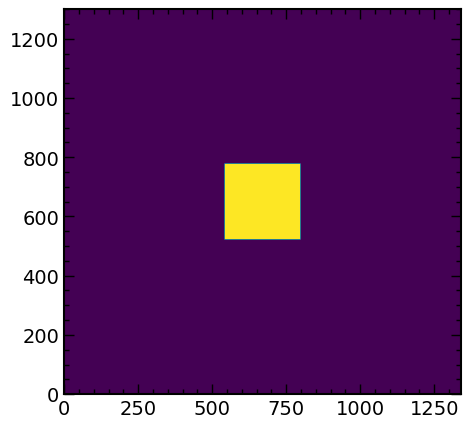

In [10]:
#Masked image (100x100 flat region)
boxsize=256
bh=boxsize//2
xcen = Ncol//2
ycen = Nrow//2
#ycen=Nrow-xcen

mask=np.zeros((Nrow,Ncol))
mask[ycen-bh:ycen+bh,xcen-bh:xcen+bh]=1
plt.imshow(mask,origin='upper',extent=(0,1340,0,1300))

In [11]:
signal = []
wavelength = []
lam_list = list(qe_path.glob('*'))

print("== Load frames ==")
for m, lam_path in enumerate(lam_list):
    #if lam_path.suffix == '.txt': continue
    wavelength.append(int(lam_path.stem[:-2]))
    flat_frame_list = list(lam_path.glob('frame*.txt')) #to exclude readme.txt
    hdrs, flat_tmp = frame_bulk_loader(flat_frame_list, label=f'{acq}_{g} / Wavelength = {lam_path.stem}', header=True)
    
    Ncycle = len(hdrs[hdrs['Exposure']==hdrs['Exposure'][0]]) #the number of iterations per each exposure time
    tarr = np.unique(hdrs['Exposure'].values) #Exposure time array
    
    #Generate master illuminated bias
    tmp_bias = flat_tmp[hdrs['Exposure']==0.].reshape(-1,Ncol*Nrow) #illuminated bias 
    tmp_master_bias,_,_ = sigma_clipped_stats(tmp_bias,axis=0,sigma=3.)
    tmp_master_bias = tmp_master_bias.reshape(Nrow,Ncol)
    
    corr = flat_tmp - tmp_master_bias #True signal
    #Crop central region for ensure uniformity
    corr_clipped = corr[:,ycen-bh:ycen+bh,xcen-bh:xcen+bh] 
    
    #Release memories
    del tmp_bias; gc.collect() 
    del flat_tmp; gc.collect()
    
    #Calculate mean signal
    tmp_signal = []
    for k in range(len(tarr)):
        tmask = (hdrs['Exposure']==tarr[k]) 
        E = np.mean(corr_clipped[tmask],axis=0)
        S = np.mean(E)
        tmp_signal.append(S)
    signal.append(tmp_signal)
signal, wavelength = np.array(signal) , np.array(wavelength)

== Load frames ==


LN_Low / Wavelength = 950nm: 100%|█████████████████████████████████████████████████████| 66/66 [00:13<00:00,  4.90it/s]


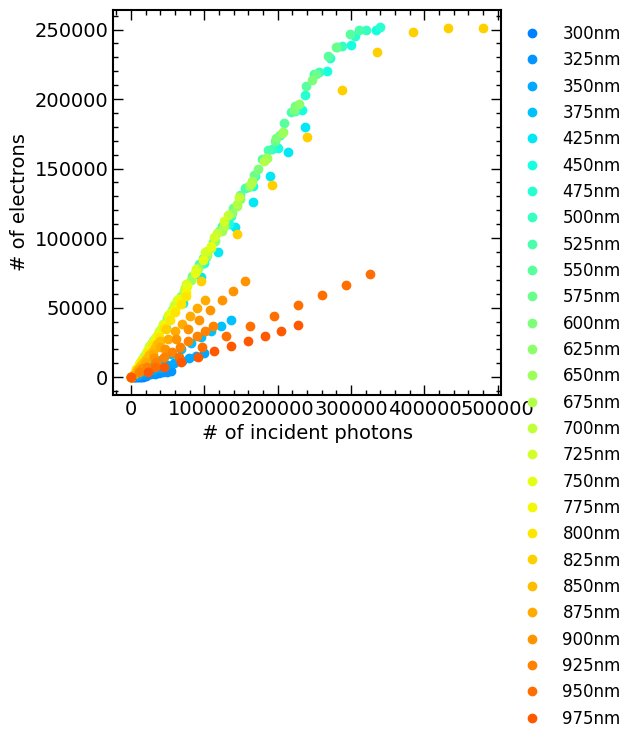

In [110]:
#Photon number flux
dNdt = P/(h*c/(wavelength*1e-9))*(w_pixel/w_sensor)**2

QE = np.zeros(len(wavelength))
QE_err = np.zeros(len(wavelength))

plt.figure(figsize=(5,5))
for i in range(len(wavelength)):
    mask = np.where((signal[i]<50000) & (signal[i]>0))
    signal_cut, t_cut = signal[i][mask], tarr[mask]/1000
    popt, pcov = curve_fit(linear,dNdt[i]*t_cut/G,signal_cut)
    perr = np.sqrt(np.diag(pcov))
    QE[i], QE_err[i]=popt[0],perr[0]
    plt.plot(dNdt[i]*tarr/1000,G*signal[i],c=cm.jet(wavelength[i]/1200),marker='o',ls='None',label=f"{wavelength[i]}nm")

QE /= 0.95
#Interpolation
lams = np.linspace(2900,10000,1000)
fQE = CubicSpline(wavelength*10,QE*100,bc_type='natural')

plt.xlabel("# of incident photons")
plt.ylabel("# of electrons")
plt.legend(frameon=False,fontsize=12,loc='upper left',bbox_to_anchor=(1.0,1.0))

## Reference QE curve from Datasheet

In [30]:
ref_qe_path = root_path / "QE_manufacture.csv"
df_ref = pd.read_csv(ref_qe_path,sep=',')
df_ref.sort_values(by='wavelength',axis=0, inplace=True)
ref_lam, ref_QE = df_ref['wavelength'].values*10, df_ref['QE'].values
fQEref = CubicSpline(ref_lam, ref_QE)

## QE curve

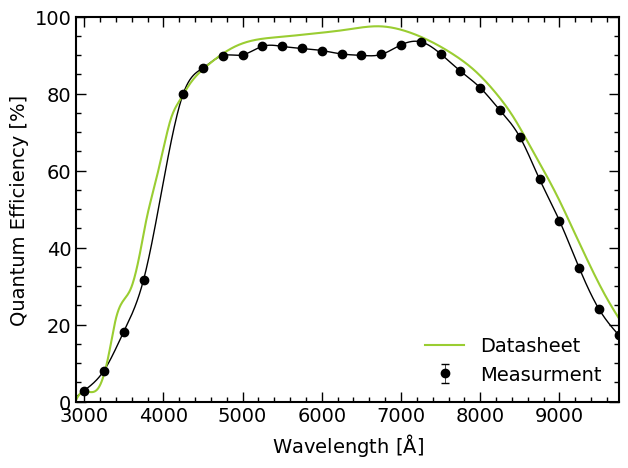

In [111]:
plt.errorbar(wavelength*10,QE*100,yerr=QE_err*100,ls='None',marker='o',c='k',capsize=3,lw=0.5,label='Measurment')
plt.plot(lams,fQE(lams),color='k',lw=1)
plt.plot(lams,fQEref(lams),color='yellowgreen',label='Datasheet')
plt.xlabel("Wavelength $[\\rm \\AA]$")
plt.ylabel("Quantum Efficiency [%]")
#plt.axvline(3750,ls='dotted',color='gray')
#plt.axvline(7500,ls='dotted',color='gray')
plt.ylim(0,100)
plt.xlim(2900,9750)
plt.legend(loc='lower right',fontsize=14)
#plt.savefig(fig_path/'QE.png',dpi=300)